# Topological Data Analysis of a Financial Time Series for insights from Landscapes for detecting Financial Crashes
# ----------------------------------------------------------------------------------------
## Hammoutene Sarah Lina - Mohan Siddharth
### ESSEC Business School & CentraleSupelec

# -----------------------------------------------------------------------------

# Install and load the packages

In [187]:
#install.packages("TDA", dependencies=TRUE) 
#install.packages("Kendall")

In [175]:
library(TDA)
library(graphics)
library(reshape)
library (Matrix)
library(plyr)
library(gdata)
library(Kendall)
options(warn=-1)

# Load the data 

In [16]:
SP=read.csv('/Users/sarahlina/Documents/Cours ESSEC/DataScience Track/GMDA/Dataset/SP500.csv',header=T,sep=',')
DJIA=read.csv('/Users/sarahlina/Documents/Cours ESSEC/DataScience Track/GMDA/Dataset/DowJones.csv',header=T,sep=',')
NASDAQ=read.csv('/Users/sarahlina/Documents/Cours ESSEC/DataScience Track/GMDA/Dataset/Nasdaq.csv',header=T,sep=',')
Russell=read.csv('/Users/sarahlina/Documents/Cours ESSEC/DataScience Track/GMDA/Dataset/Russell2000.csv',header=T,sep=',')

# Pre processing 

- Reverse the time series to re order them
- Select the Adj.Close column for the 4 indices
- Compute the log return

In [17]:
# Pre processing 
SP =SP[nrow(SP):1,]
SP = subset(SP, select=c("Date","Adj.Close"))
SP = rename(SP, c("Adj.Close"="SP500-Adj.Close"))

DJIA =DJIA[nrow(DJIA):1,]
DJIA = subset(DJIA, select=c("Date","Adj.Close"))
DJIA = rename(DJIA, c("Adj.Close"="DJIA-Adj.Close"))

NASDAQ =NASDAQ[nrow(NASDAQ):1,]
NASDAQ = subset(NASDAQ, select=c("Date","Adj.Close"))
NASDAQ = rename(NASDAQ, c("Adj.Close"="NASDAQ-Adj.Close"))

Russell =Russell[nrow(Russell):1,]
Russell = subset(Russell, select=c("Date","Adj.Close"))
Russell = rename(Russell, c("Adj.Close"="Russell-Adj.Close"))

data = merge(SP,DJIA, by="Date",all=T )
data = merge(data,NASDAQ, by="Date",all=T )
data = merge(data,Russell, by="Date",all=T )

dataset <- matrix(0, nrow(data), 4)

for(i in 2:nrow(data)) {
  for(j in 2:ncol(data)) {
    #rij = log(Pi,j / Pi-1,j)
    dataset[i,j-1] = log (data[i,j] / data[i-1,j])    
  }
}

- Plot the time seties to get an idea about the data 

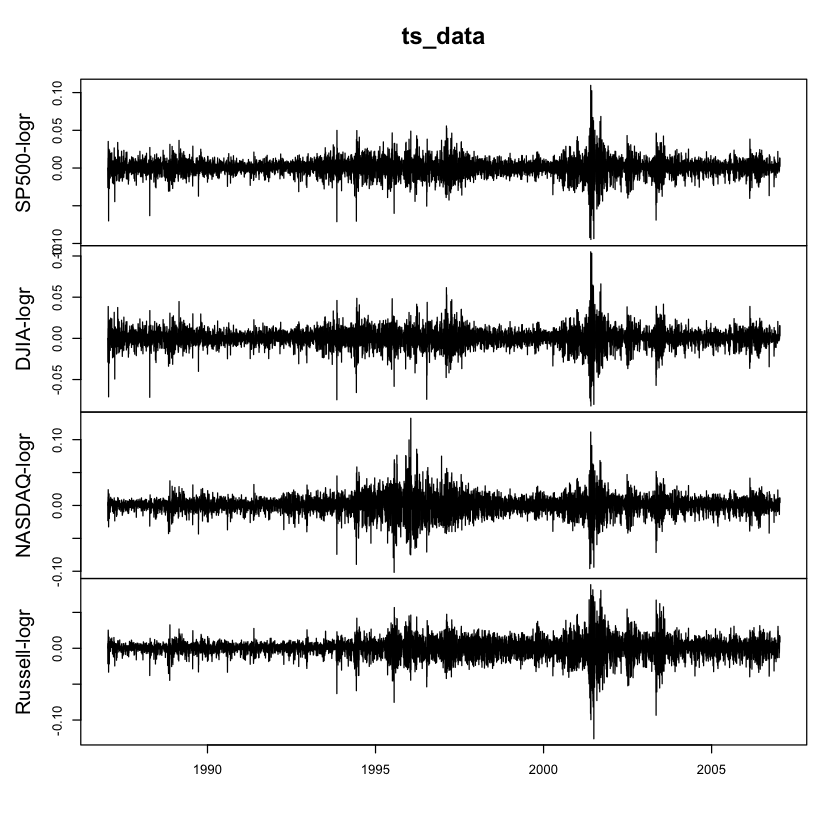

In [31]:
dimnames <- list("SP500-logr", "DJIA-logr" , "NASDAQ-logr", "Russell-logr")
ts_data <- data.frame(dataset)
colnames(ts_data) <- c("X1"="SP500-logr", "X2"="DJIA-logr" , "X3"="NASDAQ-logr", "X4"="Russell-logr" )
ts_data= ts(ts_data, start=c(1987,12,23), frequency=365)
plot(ts_data, xlab = "",ylab = "")

# ------------------------------------------------------------------------
#  Functions Definition
# ------------------------------------------------------------------------

## 1/ Construct a landscape

- We define the function that computes persistence landscapes. 
- The function take as input a persistence diagram dgm (in the Gudhi format), a dimension k, the endpoints xmin,xmax of an interval, the number nbnodes of nodes of a regular grid on the interval [xmin,xmax] and a number of landscapes nbld, and output a nbld × nbnodes array storing the values of the first nbld landscapes of dgm on the node of the grid.

In [10]:
landscape_construct <- function(dgm, k = 1, x_min=min(dgm[, 2:3]) , x_max= max(dgm[, 2:3]), nb_nodes=500, nb_ld =1)
{
  
  #Test if there is no error in the outputs 
  # x_min and x_max are the min and max of birth dates and death dates
  
  if (((class(dgm) != "diagram" && class(dgm) != "matrix" &&
        !is.data.frame(dgm)) || NCOL(dgm) != 3) &&
      (!is.numeric(dgm) || length(dgm) != 3)) {
    stop("Diagram should be a diagram, or a P by 3 matrix")
  }
  if (!is.numeric(k) || length(k) != 1 || k < 0) {
    stop("k should be an nonnegative integer")
  }
  if (!is.numeric(nb_ld) || any(nb_ld <= 0)) {
    stop("nb_ld should be a vector of positive integer")
  }
  if (!is.numeric(x_min) || !is.numeric(x_max)  ) {
    stop("x_min and x_max should be numeric")
  }
  
  #Start constructing the landscape
  tseq = seq(x_min, x_max, length = nb_nodes)
  
  if (is.numeric(dgm)) {
    dgm <- matrix(dgm, ncol = 3, dimnames = list(NULL, names(dgm)))
  }
  
  isNA <- length(which(dgm[, 1] == k))
  if (isNA == 0) {
    return(rep(0, length(tseq))) #in case there are no features with k "k"
  }
  
  dgm <- dgm[which(dgm[,1] == k), , drop = FALSE]  
  nb_rows <- nrow(dgm)
  
  fab <- matrix(NA, nrow = length(tseq), ncol = nb_rows)
  my_landscape <- numeric()
  for (j in seq_len(nb_rows)) {    
    fab[, j]  <- sapply(seq(along = tseq), FUN = function(i) {
      max(min(tseq[i] - dgm[j, 2], dgm[j, 3] - tseq[i]), 0)
    })
  }
  my_landscape <- sapply(seq(along = tseq), FUN = function(i) {
    sort(fab[i, ], decreasing = TRUE)[nb_ld]
  })
  my_landscape[is.na(my_landscape)] <- 0
  if (length(nb_ld) == 1) {
    my_landscape <- matrix(my_landscape)
  } else {
    my_landscape <- t(my_landscape)
  }
  return(my_landscape)
}


## 2/ Return the rips diagram and the correponsing landscape for a given date and a certain window size

In [61]:
get_ripsDiagram_Landscape <- function (date_given , window_size = 50)
{
  par(mfrow=c(1,2))
  idx = which(Russell$Date == date_given)[1]
  #construct the window
  window = dataset[(idx-window_size+1):idx , ] 
  #compute the rips diagram
  DiagRips <- ripsDiag(X = window, maxdimension, 0.05,library = "GUDHI",dist = "euclidean", location = TRUE, printProgress = TRUE)
  plot(DiagRips[["diagram"]], main = date_given)
  #construct the corresponding landscape
  Land = landscape_construct(DiagRips[["diagram"]], 1 , 0 , 0.05 , 500 , 1)
  plot(Land)
}

## 3/ Return the norms of the lansdscapes given a window and a dataset 

- Build the window
- Compute the rips diagram
- Construct its corresponding persistance landscape
- Computes L1 and L2 of the landscape
- Return a matrix containing to 2 norms for all the points in the dataset 

In [190]:
get_norms<- function (dataset , window_size = 50)
#Default value for the window_size = 50 in case it s not specified
{
    norms <- matrix(0, nrow(data), 2)
    maxdimension <- 1    # we are interested in loops

    for(i in window_size: (nrow(dataset))) {
      idx2= i 
      idx1= i-window_size+1
      window = dataset[idx1:idx2,]
      DiagRips <- ripsDiag(X = window, maxdimension,0.05,library = "GUDHI", dist = "euclidean",location = FALSE, printProgress = FALSE)
      Land = landscape_construct(DiagRips[["diagram"]], 1 , 0 , 0.05 , 1000 , 1)
      norms[i,1]= norm(as.matrix(Land), type="1") 
      norms[i,2]= norm(as.matrix(Land), type="2") 
    }
    
    return (norms)
}

## 4/ Transform to time series

- An important note is that the data has missing dates, which corresponded to weekends.  So applying the default timeseries function would shift the results.  In order to resolve this, we enter values of zero for dates of weekend followed by the application of the time series function.

In [71]:
to_timeserie <- function(data , strating_year, strating_date)
{
    passage_matrix_1<-cbind(t(matrix(c(data,c(0,0,0,0)),nrow = 5)),0,0)
    passage_1<-as.numeric(unmatrix( passage_matrix_1  ,byrow=T))
    passage_1<-passage_1[1:(length(passage_1)-6)]
    timeseries_1 = ts(passage_1,  frequency = 365, start = c(strating_year, as.numeric(format(as.Date(strating_date), "%j"))))
    return (timeseries_1)
}

## 5/ Plot the two norms between 2 dates 

- Get the norms between the 2 specified dates
- Transform it into time serie
- Filter and remove the weekends from the time setie
- Plot the resutl

In [110]:
plot_norms_between_two_dates <- function(norms, starting_year, starting_date, ending_date)
{
    idx1 = which(Russell$Date == starting_date)[1]
    idx2 = which(Russell$Date == ending_date)[1]
    
    ts_norm1= norms[idx1:idx2,1]
    ts_norm2= norms[idx1:idx2,2]
   
    ts_norm1_normalized = (ts_norm1 -mean(ts_norm1) )/ var(ts_norm1)
    ts_norm1_normalized= ts_norm1/12

    timeseries_1= to_timeserie (ts_norm1_normalized,starting_year,starting_date)
    timeseries_2= to_timeserie (ts_norm2,starting_year, starting_date)
    
    plot(timeseries_1[timeseries_1>0],axes=F , type="l",col="red")
    lines (timeseries_2[timeseries_2>0],axes=F , type="l",col="blue")

    date<-seq(from=as.Date(starting_date),by=1,length.out=length(timeseries_1))
    axis(1, at=1:length(timeseries_1[timeseries_1>0]), labels=date[timeseries_1>0])
    #Red for L1 and Blue for L2
 }

# ------------------------------------------------------------------------
#  Window = 50
# ------------------------------------------------------------------------

## 1. Plot the L1 and L2 norms for the 2 crashes

In [191]:
norms = get_norms(dataset, 50)

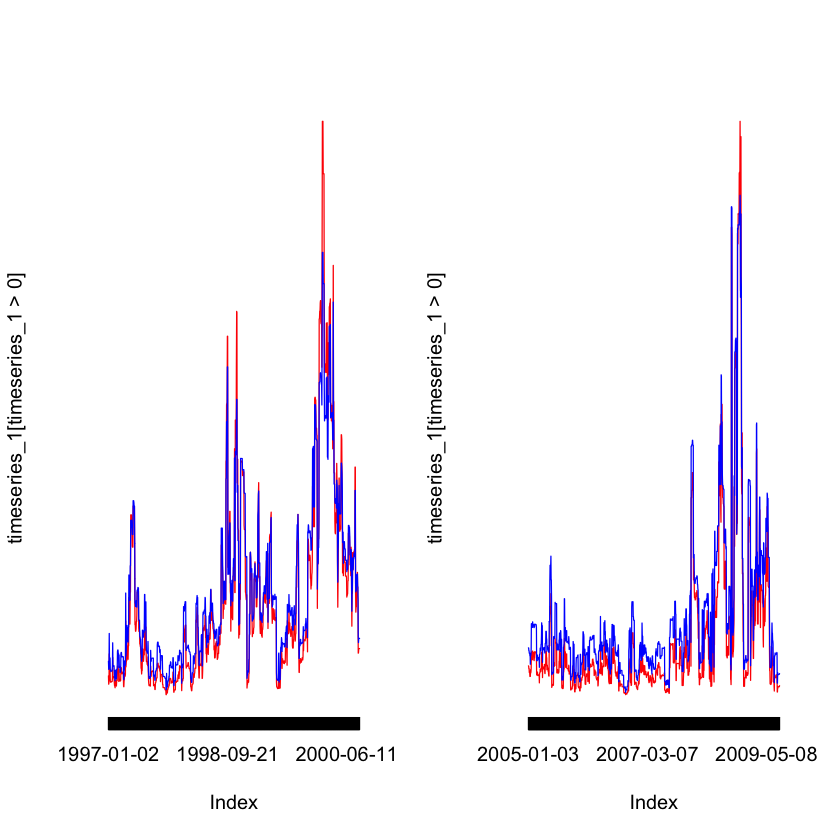

In [114]:
################################################
#Plot the norms
################################################

par(mfrow=c(1,2))
plot_norms_between_two_dates (norms,1987, '1997-01-02','2000-10-02' )
plot_norms_between_two_dates (norms,2005, '2005-01-03','2009-10-02' )

## 2. Rips Diagrams for the two periods of interest

# Generated complex of size: 16085 
# Persistence timer: Elapsed time [ 0.000000 ] seconds
# Generated complex of size: 9429 
# Persistence timer: Elapsed time [ 0.000000 ] seconds


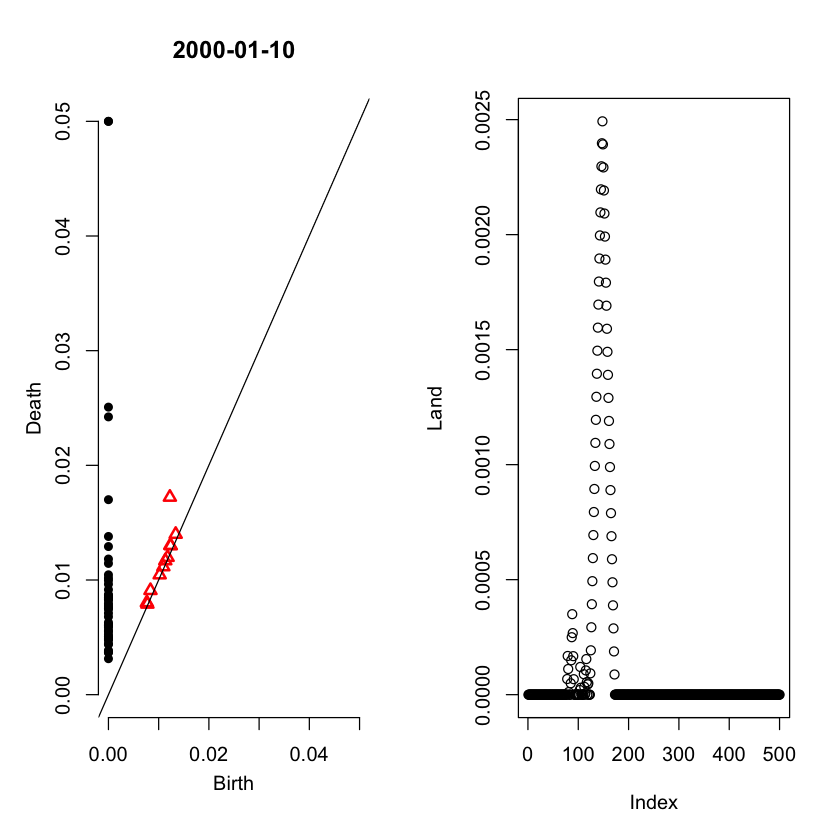

# Generated complex of size: 14398 
# Persistence timer: Elapsed time [ 0.000000 ] seconds


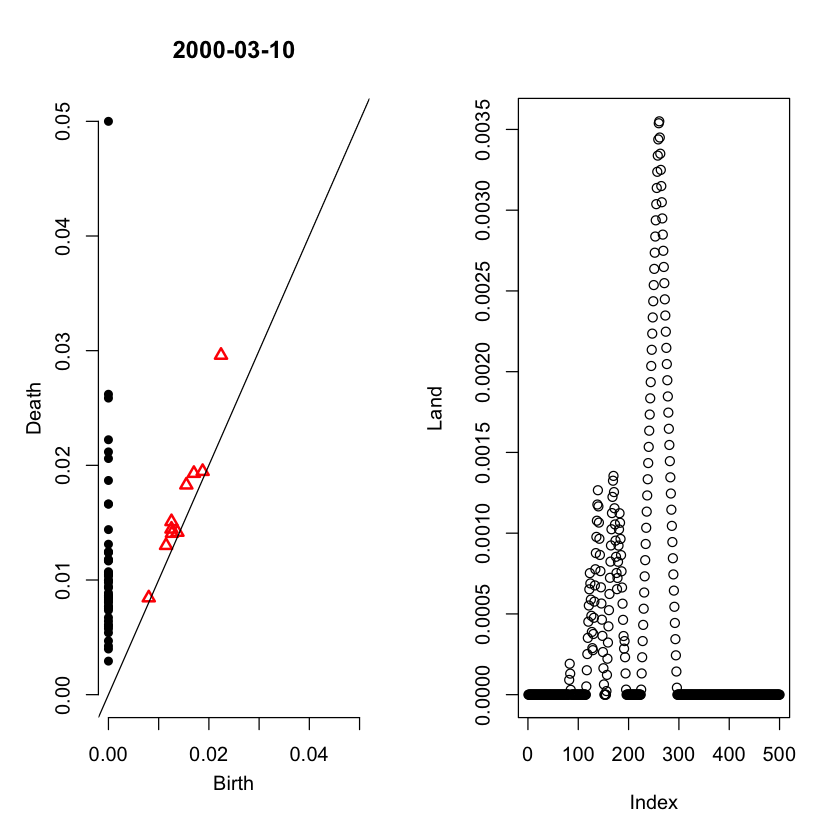

# Generated complex of size: 10005 
# Persistence timer: Elapsed time [ 0.000000 ] seconds


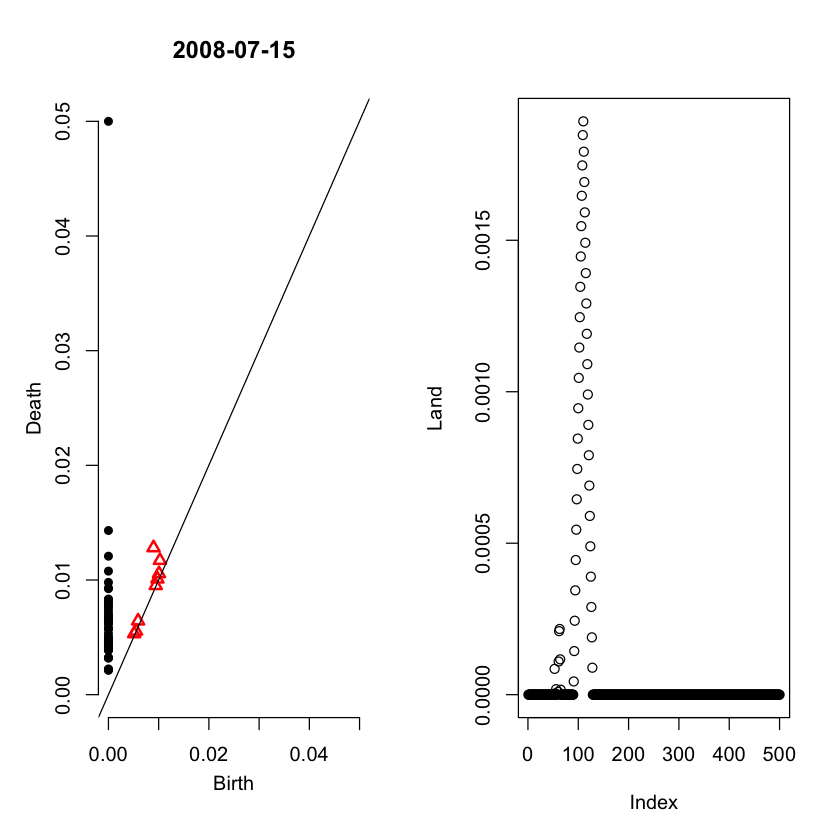

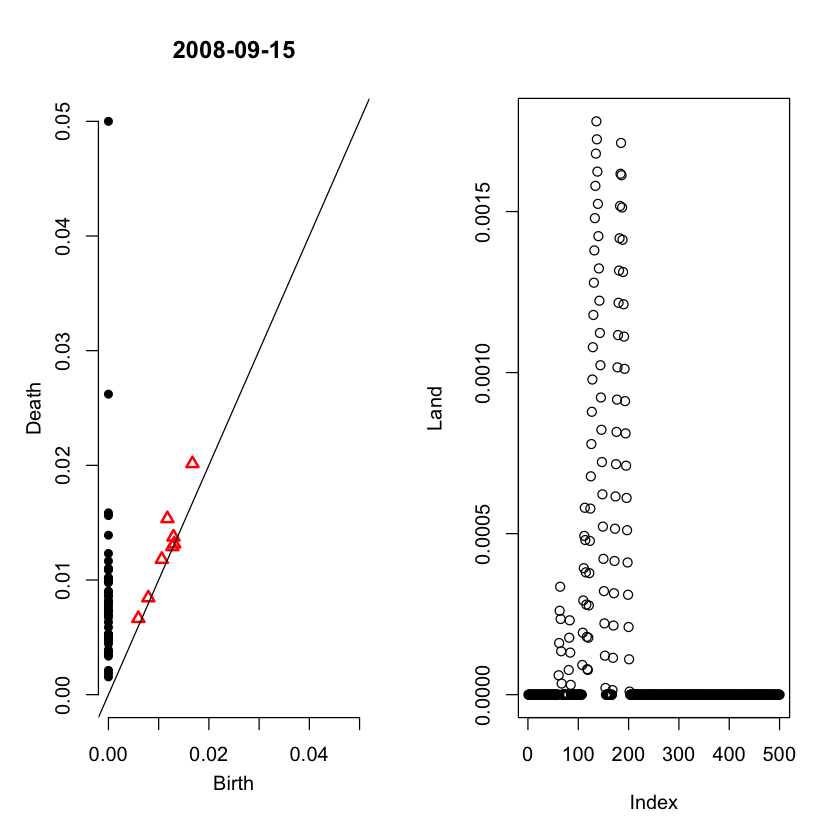

In [65]:
get_ripsDiagram_Landscape ('2000-01-10', 50)
get_ripsDiagram_Landscape ('2000-03-10', 50)
get_ripsDiagram_Landscape ('2008-07-15', 50)
get_ripsDiagram_Landscape ('2008-09-15', 50)

# ------------------------------------------------------------------------
#  Window = 40
# ------------------------------------------------------------------------

## 1. Plot the L1 and L2 norms for the 2 crashes

In [192]:
norms_40 = get_norms (dataset, 40)

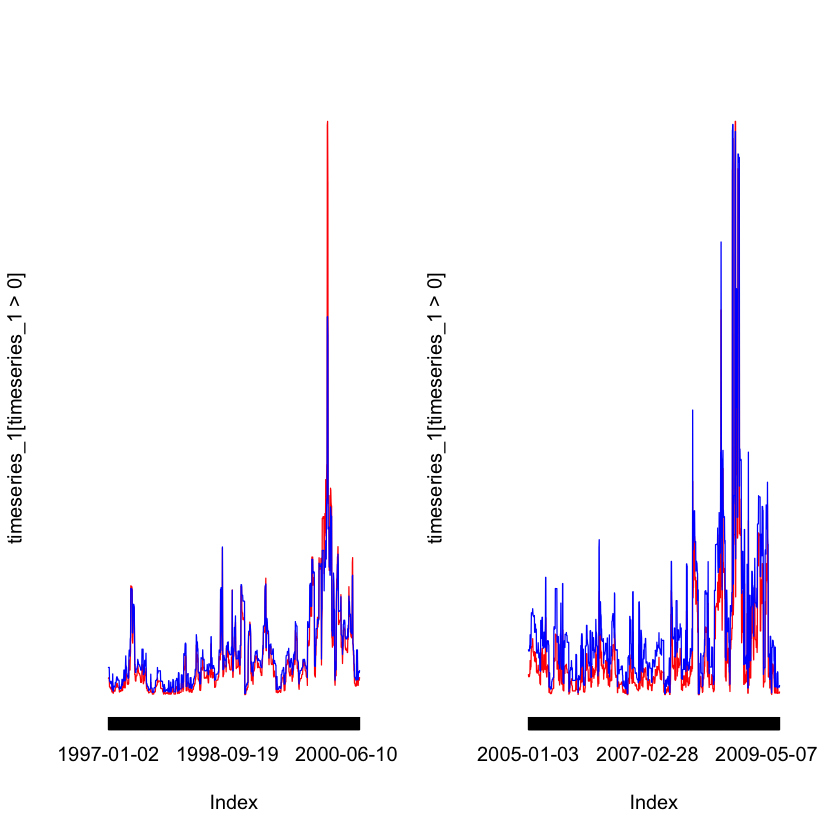

In [115]:
################################################
#Plot the norms
################################################

par(mfrow=c(1,2))
plot_norms_between_two_dates (norms_40,1987, '1997-01-02','2000-10-02' )
plot_norms_between_two_dates (norms_40,2005, '2005-01-03','2009-10-02' )

## 2. Rips Diagrams and landscapes for the periods dates of interest

# Generated complex of size: 7669 
# Persistence timer: Elapsed time [ 0.000000 ] seconds
# Generated complex of size: 5727 
# Persistence timer: Elapsed time [ 0.000000 ] seconds


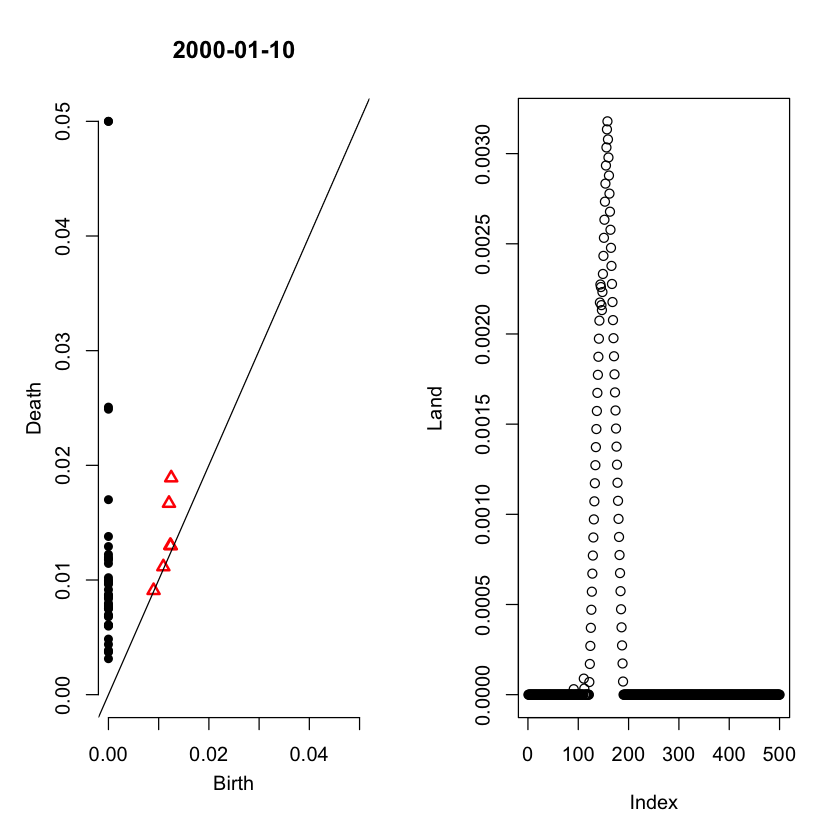

# Generated complex of size: 7006 
# Persistence timer: Elapsed time [ 0.000000 ] seconds


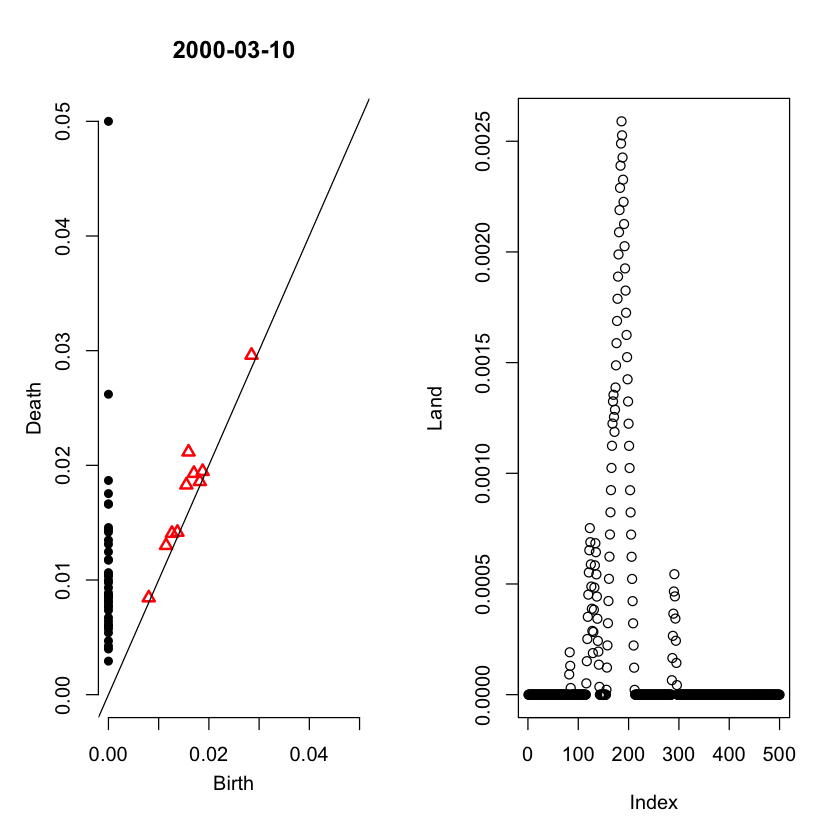

# Generated complex of size: 5210 
# Persistence timer: Elapsed time [ 0.000000 ] seconds


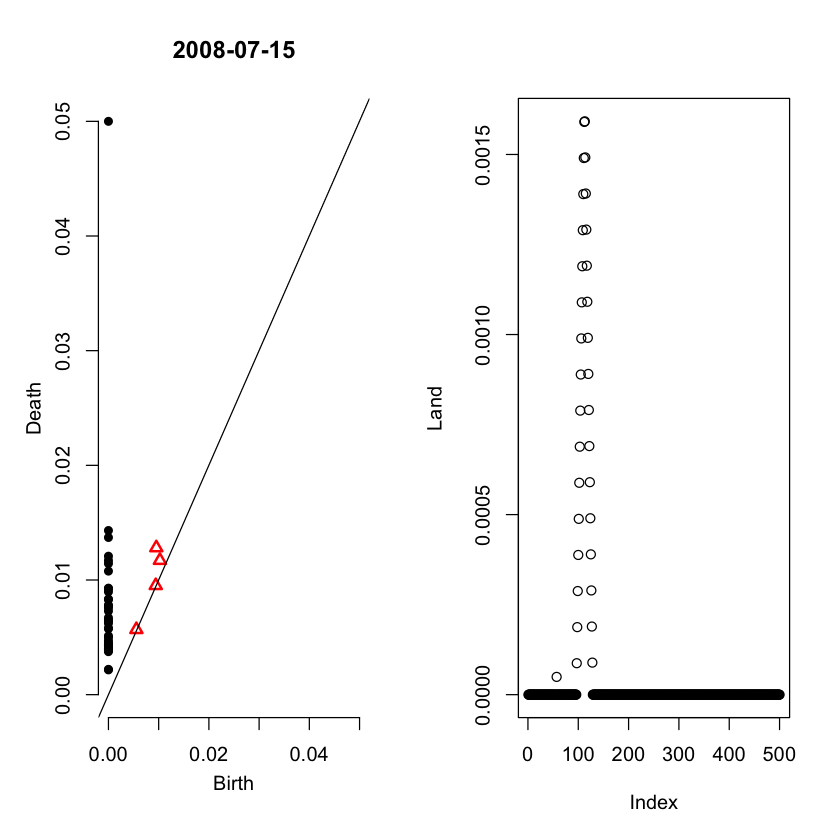

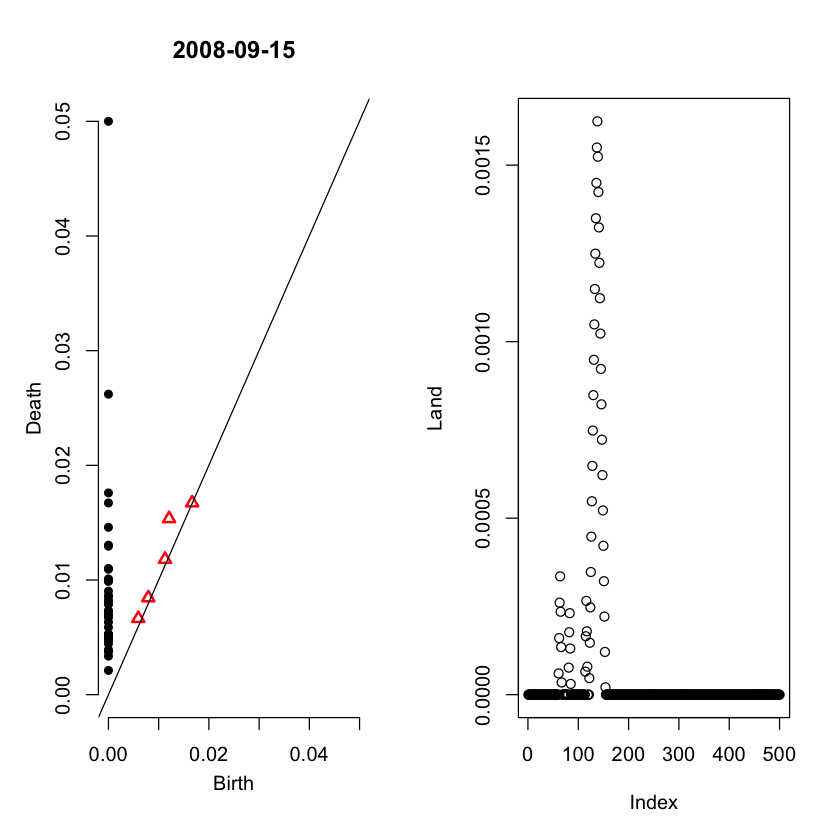

In [62]:
get_ripsDiagram_Landscape ('2000-01-10', 40)
get_ripsDiagram_Landscape ('2000-03-10', 40)
get_ripsDiagram_Landscape ('2008-07-15', 40)
get_ripsDiagram_Landscape ('2008-09-15', 40)

# ------------------------------------------------------------------------
#  Window = 80
# ------------------------------------------------------------------------

## 1. Plot the L1 and L2 norms for the 2 crashes

In [193]:
norms_80 = get_norms (dataset, 80)

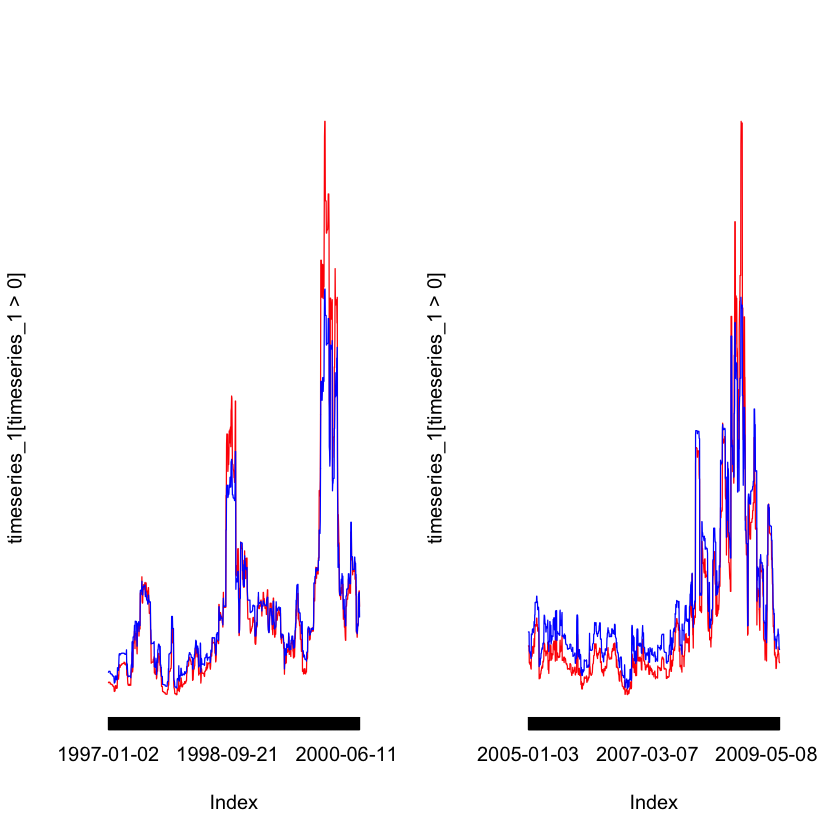

In [116]:
################################################
#Plot the norms
################################################

par(mfrow=c(1,2))
plot_norms_between_two_dates (norms_80,1987, '1997-01-02','2000-10-02' )
plot_norms_between_two_dates (norms_80,2005, '2005-01-03','2009-10-02' )

# --------

## 2. MannKendall Test

In [184]:
#L1
norm80_1 = to_timeserie(norms_80[,1],1987, '1987-12-23')
res <-  MannKendall(norm80_1)
print(res)
summary(res)

tau = 0.0229, 2-sided pvalue =0.00077891
Score =  1142769 , Var(Score) = 115660693504
denominator =  49929492
tau = 0.0229, 2-sided pvalue =0.00077891


In [185]:
#L2
norm80_2 = to_timeserie(norms_80[,2],1987, '1987-12-23')
res <-  MannKendall(norm80_2)
print(res)
summary(res)

tau = 0.0246, 2-sided pvalue =0.00030911
Score =  1226877 , Var(Score) = 115660693504
denominator =  49929488
tau = 0.0246, 2-sided pvalue =0.00030911


## 3. Rips Diagrams and landscapes for the  dates of interest

# Generated complex of size: 60394 
# Persistence timer: Elapsed time [ 0.000000 ] seconds
# Generated complex of size: 50718 
# Persistence timer: Elapsed time [ 0.000000 ] seconds


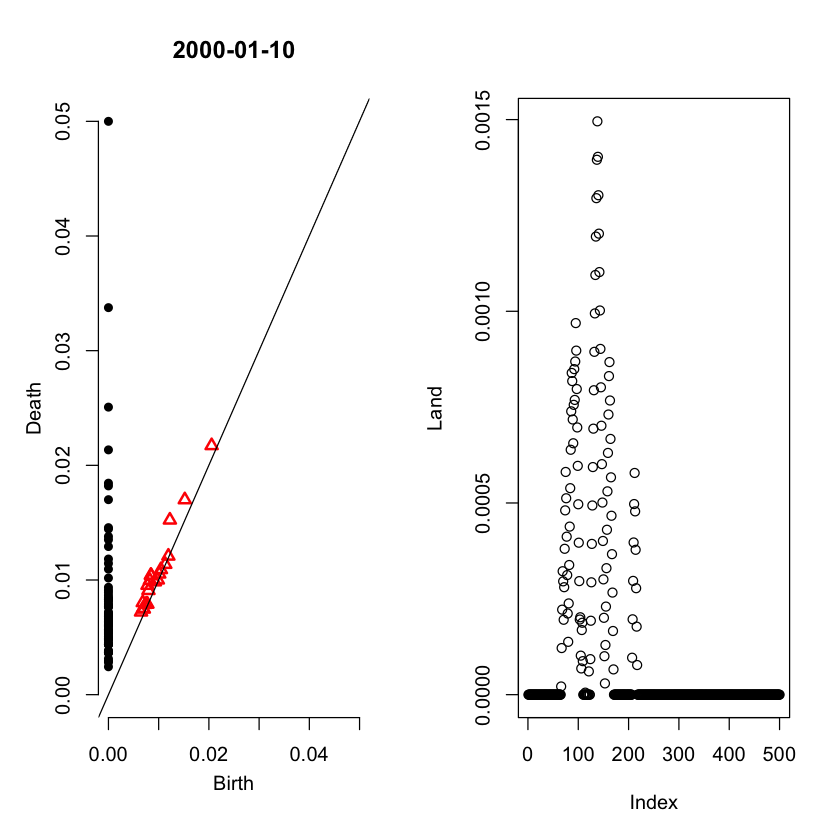

# Generated complex of size: 57715 
# Persistence timer: Elapsed time [ 0.000000 ] seconds


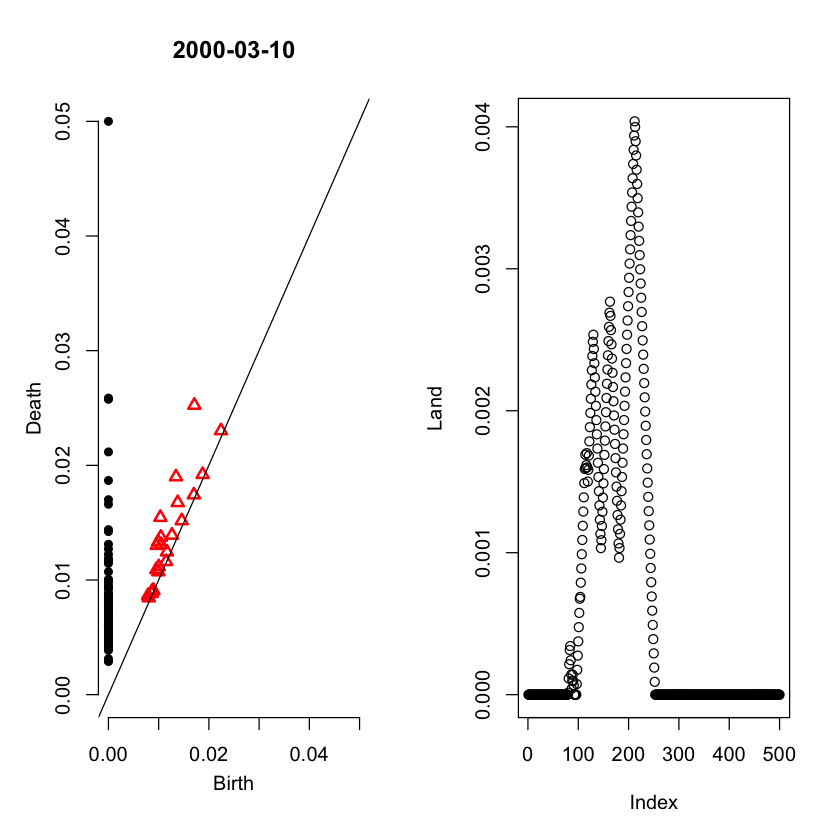

# Generated complex of size: 46142 
# Persistence timer: Elapsed time [ 0.000000 ] seconds


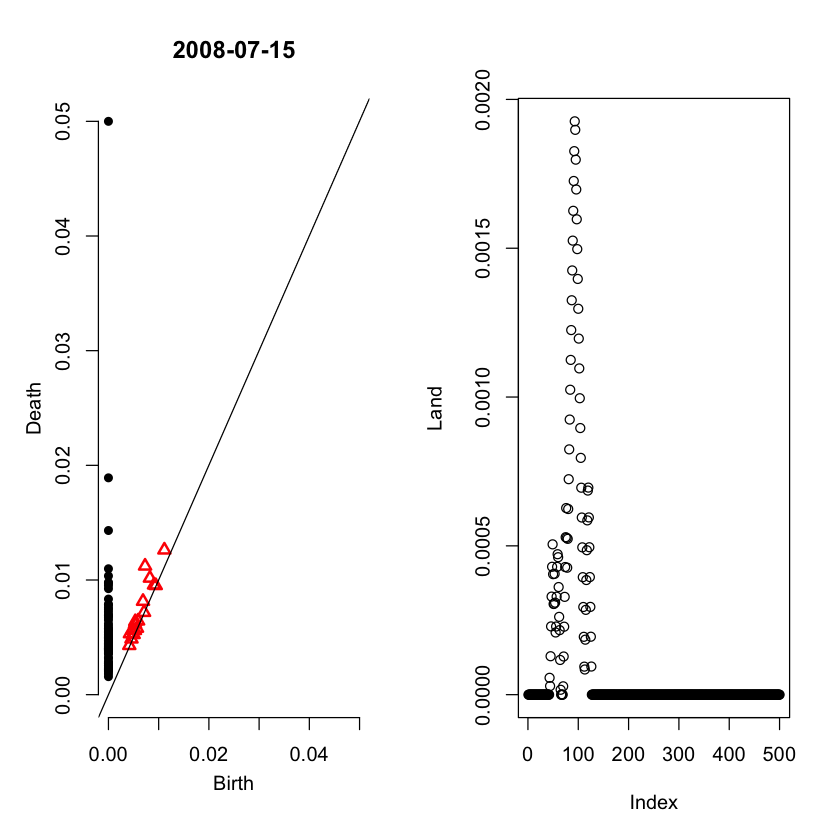

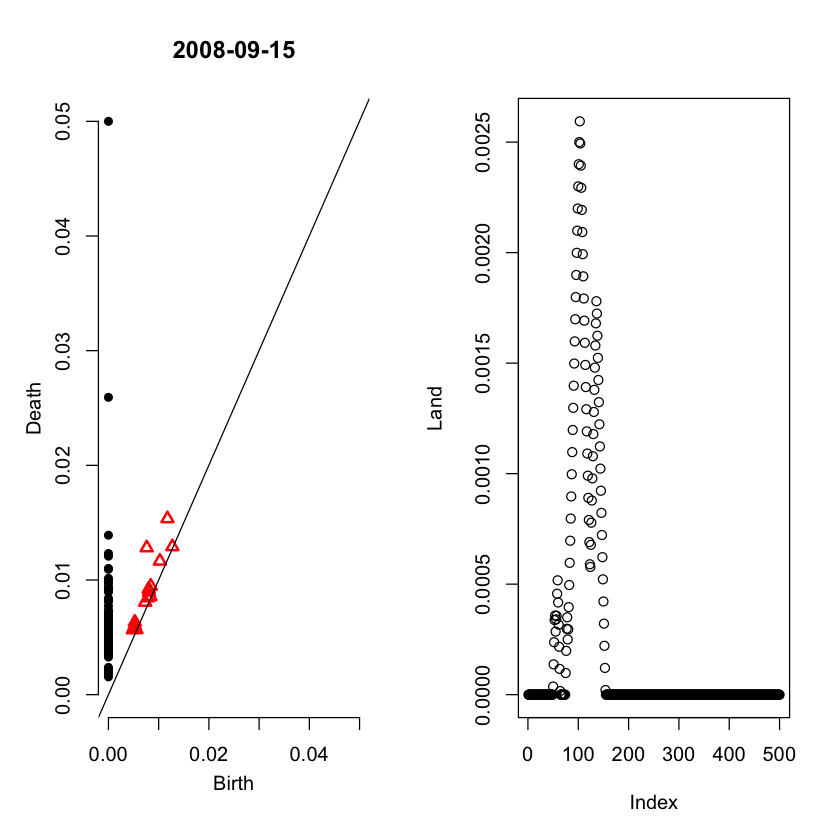

In [64]:
get_ripsDiagram_Landscape ('2000-01-10', 80)
get_ripsDiagram_Landscape ('2000-03-10', 80)
get_ripsDiagram_Landscape ('2008-07-15', 80)
get_ripsDiagram_Landscape ('2008-09-15', 80)

# ------------------------------------------------------------------------
#  Window = 120
# ------------------------------------------------------------------------

## 1. Plot the L1 and L2 norms for the 2 crashes

In [194]:
norms_120 = get_norms (dataset, 120)

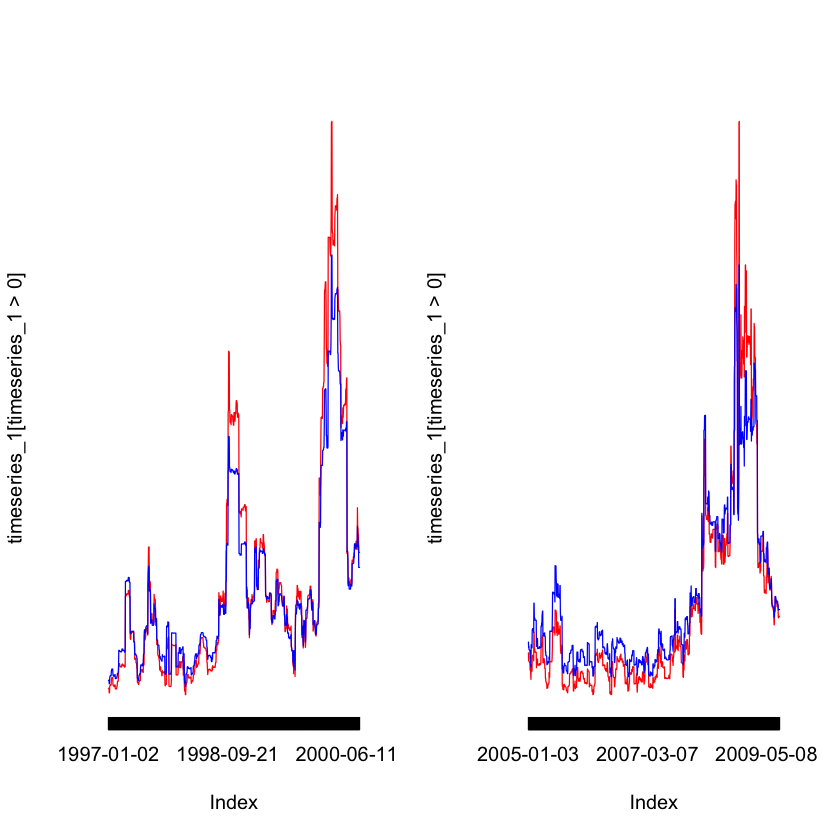

In [119]:
################################################
#Plot the norms
################################################

par(mfrow=c(1,2))
plot_norms_between_two_dates (norms_120,1987, '1997-01-02','2000-10-02' )
plot_norms_between_two_dates (norms_120,2005, '2005-01-03','2009-10-02' )

## 2. Rips Diagrams and landscapes for the  dates of interest

# Generated complex of size: 205547 
# Persistence timer: Elapsed time [ 0.000000 ] seconds
# Generated complex of size: 181251 
# Persistence timer: Elapsed time [ 0.000000 ] seconds


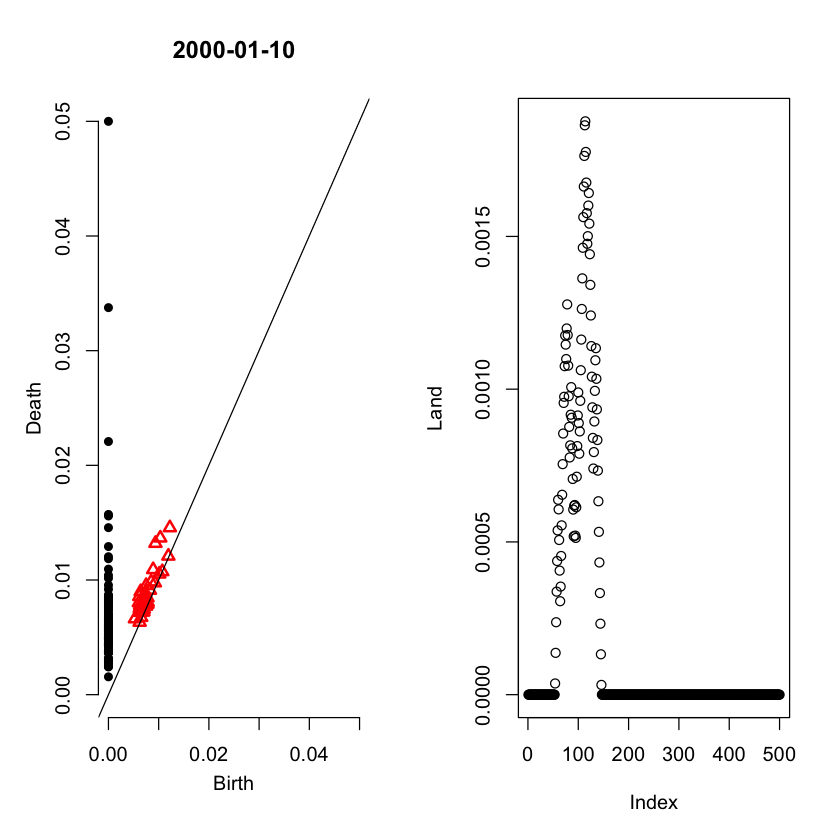

# Generated complex of size: 174418 
# Persistence timer: Elapsed time [ 0.000000 ] seconds


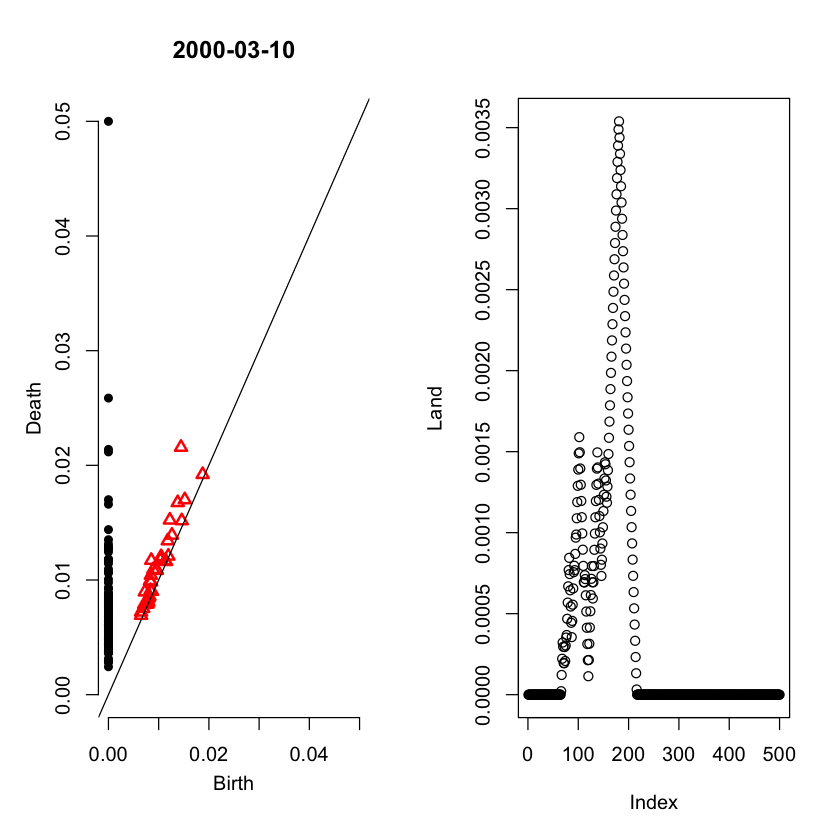

# Generated complex of size: 173046 
# Persistence timer: Elapsed time [ 0.000000 ] seconds


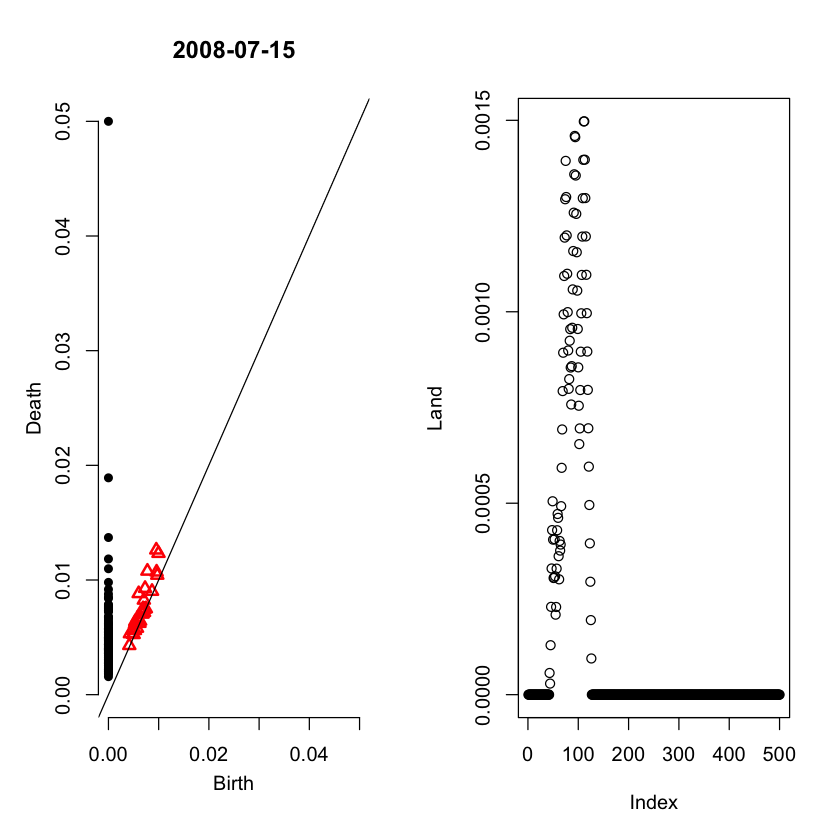

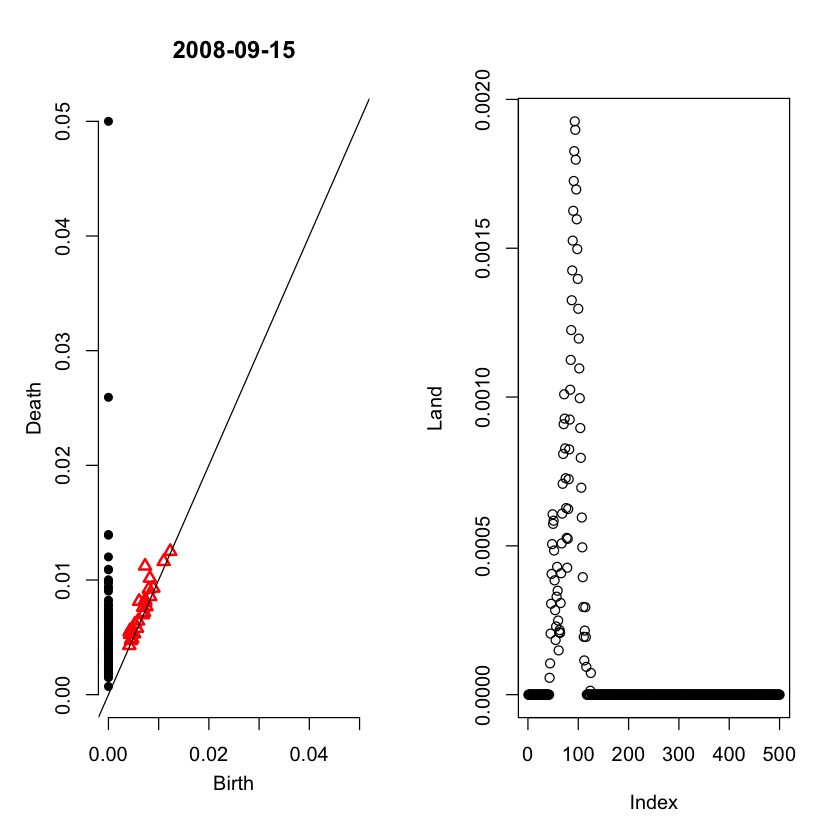

In [69]:
get_ripsDiagram_Landscape ('2000-01-10', 120)
get_ripsDiagram_Landscape ('2000-03-10', 120)
get_ripsDiagram_Landscape ('2008-07-15', 120)
get_ripsDiagram_Landscape ('2008-09-15', 120)

# ------------------------------------------------------------------------
# Bottleneck distances
# ------------------------------------------------------------------------

- Build the window
- We loop through the dataset 
    - We compute the rips diagram
    - We compute the Bottleneck distance between the current rips diagram and the previous one 
    - We save the distance 
    - We save the current rips diagram as previous diagram

In [197]:
maxdimension <- 1    # components and loops
window_size <- 80
List_DiagRips = NULL

bottleneck_distances = NULL
rbind(bottleneck_distances, 0)

prev_diag = NULL

for(i in window_size: (nrow(dataset))) {
    idx2= i 
    idx1= i-window_size+1
    window = dataset[idx1:idx2,]
    
    current_diag <- ripsDiag(X = window, maxdimension,0.05,library = "GUDHI", dist = "euclidean",location = FALSE, printProgress = FALSE)
    if (!is.null(prev_diag))
        {
            distance= bottleneck(current_diag[["diagram"]], prev_diag[["diagram"]] , dimension=1)
            bottleneck_distances = rbind(bottleneck_distances,distance)
        }
    prev_diag = current_diag    
}

0


- We transform the distance array to time serie and we plot the result

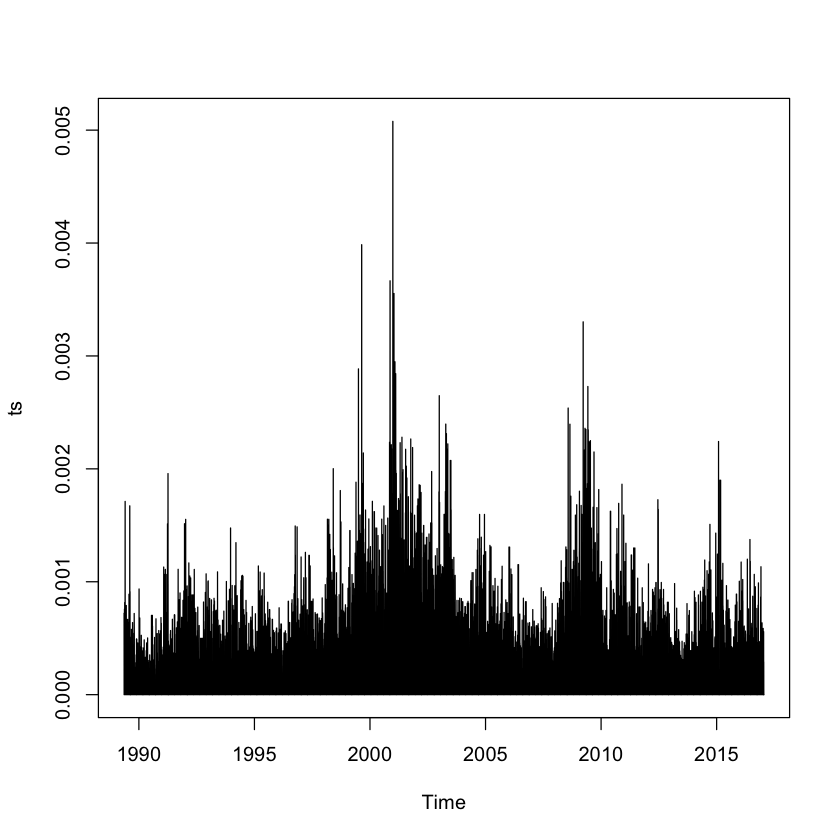

In [173]:
ts = to_timeserie (bottleneck_distances , 1989, "1989-05-11")
plot(ts)